**Resouces:**

Explanation on the resnet architecture: input_size/output_size/kernel/stride at each layer:
https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

Resnet50 Architecture:
https://www.kaggle.com/keras/resnet50

Simple way of unpacking resnetX for stripping out FC layers and such:
https://discuss.pytorch.org/t/resnet-pretrained-model-with-last-fc-layer-stripped-does-not-work/17951

Reason as to why we want to resize each image and their labels to 224 x 224:
https://stackoverflow.com/questions/43922308/what-input-image-size-is-correct-for-the-version-of-resnet-v2-in-tensorflow-slim

How to modify the FC layer of resnet:
https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/3

**Data preprocessing requirement:**

In order to define the heatmap loss as torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True):

We need to have the target/label take on the form of (N, H, W), where the output needs to have (N, 12, H, W).

For each label tensor (H, W):
Each entry represents which join a location contains: value 1-11 are joints 1 to 11, value 0 represents no-joints at this location.

In [220]:
# Loading our own functions
import math
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from libs.data_utils import HandDataset, ToTensor, Scale
from libs.layer_utils import flatten, random_weight, zero_weight
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def show_joints(image, pos_2d, pos_3d):
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax = fig.add_subplot(2,1,1)
    height, width, depth = image.shape
    ax.imshow(image)
    ax.scatter(pos_2d[:,0], pos_2d[:, 1], s=10, marker='.', c='r')
    ax = fig.add_subplot(2,1,2, projection="3d")
    ax.view_init(-90,-90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(pos_3d[:,0], pos_3d[:,1], pos_3d[:,2], s=30)
    plt.show()

    
def makeGfilter():
    # make the guassian filter
    g_heatmap_size = 9
    g_filter = torch.zeros(g_heatmap_size, g_heatmap_size)
    for delta_x in range(-4, 5):
        x = (g_heatmap_size - 1)/2 + delta_x
        for delta_y in range(-4, 5):
            y = (g_heatmap_size - 1)/2 + delta_y
            # guassian-like heatmap
            g_filter[int(y), int(x)] = math.exp(-1.0 * (delta_x**2 + delta_y**2))
    
    return g_filter, g_heatmap_size

def makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    g_filter, g_heatmap_size = makeGfilter()
    
    # heatmap 0 based, should we have a very small number instead of 0
    heatmap = torch.zeros(pos2d_list.shape[0], num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1) # size (N, 21, 224, 224)
    one_hot = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size) # size (N, 21, 224, 224)
    # this is a quadruple loop for now, can we possibly verctorize it?
    loc_map_x = torch.zeros(pos2d_list.shape[0], num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1)
    loc_map_y = torch.zeros(pos2d_list.shape[0], num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1)
    loc_map_z = torch.zeros(pos2d_list.shape[0], num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1)
    
    # Hao: Took me a while, but eventually figured out a way to do 4D indexing
    b_idx = torch.from_numpy(np.repeat(np.arange(batch_size), num_joints)).long()
    j_idx = torch.from_numpy( np.array(list(np.arange(num_joints))*batch_size) ).long()
    h_idx = pos2d_list[:, :, 1].view(-1).long()
    w_idx = pos2d_list[:, :, 0].view(-1).long()
    
    one_hot[b_idx, j_idx, h_idx, w_idx] = 1.0
    
    padding = int((g_heatmap_size - 1)/2)
    
    # still need some loops, but at least we only need a double loop, yeahhh, I guess
    for dh in range(-4, 5):
        for dw in range(-4, 5):
            cur_h_idx = h_idx + dh + padding
            cur_w_idx = w_idx + dw + padding
            cur_h_idx = cur_h_idx.long()
            cur_w_idx = cur_w_idx.long()
            heatmap[b_idx, j_idx, cur_h_idx, cur_w_idx] = math.exp(-1.0 * (dw**2 + dh**2))
            loc_map_x[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 0].view(-1).float()
            loc_map_y[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 1].view(-1).float()
            loc_map_z[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 2].view(-1).float()

    loc_map = torch.cat((loc_map_x[:, :, padding:-padding, padding:-padding], loc_map_y[:, :, padding:-padding, padding:-padding], loc_map_z[:, :, padding:-padding, padding:-padding]), dim=1)
    return loc_map, heatmap[:, :, padding:-padding, padding:-padding], one_hot

def makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    g_filter, g_heatmap_size = makeGfilter()
    
    # heatmap 0 based, should we have a very small number instead of 0
    heatmap = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size) # size (N, 21, 224, 224)
    one_hot = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size) # size (N, 21, 224, 224)
    # this is a quadruple loop for now, can we possibly verctorize it?
    loc_map_x = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    loc_map_y = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
    loc_map_z = torch.zeros(pos2d_list.shape[0], num_joints, image_size, image_size)
            
    for b in range(0, batch_size):
        for i in range(0, num_joints):
            one_hot[b, i, int(pos2d_list[b, i, 1]), int(pos2d_list[b, i, 0])] = 1.0
            
            for delta_x in range(-4, 5):
                x = pos2d_list[b, i, 0] + delta_x
                if x > 0 and x < image_size:
                    for delta_y in range(-4, 5):
                        y = pos2d_list[b, i, 1] + delta_y
                        if y > 0 and y < image_size:
                            # guassian-like heatmap
                            heatmap[b, i, int(y), int(x)] = math.exp(-1.0 * (delta_x**2 + delta_y**2))
                            #1.0 - (delta_x**2 + delta_y**2) / 32
                            # all points around the joint take on the 3D position of the joint for our location map GT
                            loc_map_x[b, i, int(y), int(x)] = pos3d_list[b, i, 0].float()
                            loc_map_y[b, i, int(y), int(x)] = pos3d_list[b, i, 1].float()
                            loc_map_z[b, i, int(y), int(x)] = pos3d_list[b, i, 2].float()

    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    return loc_map, heatmap, one_hot

# define some constants
num_joints = 21
image_size = 224
dtype = torch.float32

transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

**Load data:**

In [233]:
import time
batch_size = 2

hand_train = HandDataset('toy_dataset.csv', transform=transform, train=True)
N = 100 #len(hand_train)
loader_train = DataLoader(hand_train, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))))

hand_val = HandDataset('toy_dataset.csv', transform=transform, train=True)
loader_val = DataLoader(hand_val, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))))

hand_test = HandDataset('toy_dataset.csv', transform=transform, train=False)
loader_test = DataLoader(hand_test, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)))

for i_batch, batch in enumerate(loader_train):
    print(i_batch, batch['image'].size())
    print(i_batch, batch['pos_2d'].size())
    print(i_batch, batch['pos_3d'].size())
    image = batch['image']
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    #print(pos2d_list.int())
    
    start_time = time.time()
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("vectorized: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    loc_map_n, heatmap_n, one_hot_n = makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("naive: --- %s seconds ---" % (time.time() - start_time))
    
    print("Check the difference between vectorized impl and naive impl:")
    print("Error:", torch.sum(loc_map - loc_map_n))
    print("Error:", torch.sum(heatmap - heatmap_n))
    print("Error:", torch.sum(one_hot - one_hot_n))
    
    #print(heatmap.shape)
    #print(loc_map[0, 0])
    #for j in range(image_size):
    #    print(heatmap[0, 0, j])
    break

0 torch.Size([2, 3, 224, 224])
0 torch.Size([2, 21, 2])
0 torch.Size([2, 21, 3])
vectorized: --- 0.03308510780334473 seconds ---
naive: --- 0.23362278938293457 seconds ---
Check the difference between vectorized impl and naive impl:
Error: tensor(0.)
Error: tensor(0.)
Error: tensor(0.)


**Build the model:**

In [238]:
def computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size):
    l_loss = 0.005 * torch.sum(torch.pow(heatmap.repeat(1, 3, 1, 1) * (l_pred - loc_map), 2)) / (batch_size * num_joints * 9**2 * 3)
    hmap_pred = nn.functional.softmax(h_pred.view(batch_size, 21, -1), dim=2)
    h_loss = torch.sum(hmap_pred * one_hot.view(batch_size, 21, -1), dim=2)
    h_loss = torch.sum(-1.0 * h_loss.log()) / (batch_size * num_joints)
    #torch.sum(torch.pow(nn.functional.softmax(y_pred[:, 63:, :, :].view(batch_size, 21, -1), dim=2) - heatmap.view(batch_size, 21, -1), 2)) / batch_size
    loss = l_loss + h_loss
    return loss

    
# Use renet 34 for speed, later may use resnet50 as our base NN stucture for joints detection
resnet34 = models.resnet34(pretrained=True)
#resnet34.cuda()
for param in resnet34.parameters():
    # don't change/update the pretrained model parameters, only change the final fc layer
    param.requires_grad = False

# Upsample using transpose convolution and unpooling
# output_padding = 1 is intended to recover proper size
transConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
# Note: the following layer should have been maxunpooling, kernel 3 x 3, stride 2
# torch.nn.MaxUnpool2d() requires modification of the torchvision resnetXX modules
# to have the maxpooling layer return indices of max values, try ConvTranspose2d() instead
# If this doesn't work, have to and implement custom version of resnet
transConv4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv5 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=7, stride=2, padding=3, output_padding=1) # (224 x 224)

# finally, the joint prediction Convolutional Layer, filter size 3 x 3, 21 filters
# VNect's 2D heatmap is generated from res4d, and location maps from res5a, we try something simpler
jointPrediction = nn.Conv2d(in_channels=64, out_channels=21, kernel_size=3, stride=1, padding=1)

# layers to generate the location maps
conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
conv7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
locationPrediction = nn.Conv2d(in_channels=128, out_channels=63, kernel_size=3, stride=1, padding=1)

# stick a bunch of ReLu non-linearity in the upsampling pipeline
model = nn.Sequential(
    *list(resnet34.children())[:-2],
    transConv1,
    nn.ReLU(),
    transConv2,
    nn.ReLU(),
    transConv3,
    nn.ReLU(),
    transConv4,
    nn.ReLU(),
    transConv5,
    nn.ReLU(),
)

modelHeatmap = nn.Sequential(
    jointPrediction
)

modelLocmap = nn.Sequential(
    conv6,
    nn.ReLU(),
    conv7,
    nn.ReLU(),
    locationPrediction
)

# use a toy model to make sure that the location map implementations are correct
#model = nn.Sequential(
#    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
#    nn.Conv2d(in_channels=64, out_channels=63, kernel_size=3, stride=1, padding=1)
#)

# model.cuda()
# .cuda() makes model run on GPU

**Training the model and evaluate on eval dataset:**

In [241]:
# optimizer using adam
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters()) + list(modelHeatmap.parameters()) + list(modelLocmap.parameters()) ), lr = 0.001)

for epoch in range(20):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_train):
        # make all the ground truth tensors needed for loss computation
        image = batch['image'].float()
        pos2d_list = batch['pos_2d'] # size (N, 21, 2)
        pos3d_list = batch['pos_3d'] # size (N, 21, 3)
        loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
        # y_pred is of size 224 x 224 x 84, and let's say the filter dimension is layed out in the following way:
        # dimension 0-20: j1_x, j2_x, j3_x,...j21_x, dimension 21-41: j1_y, j2_y, j3_y, ... 
        # Above is for conveniently using broadcasting with heatmap element-wise product
        # y_pred is the predicted location maps + 2Dheatmap for all 21 joints
        y_pred = model(image)
        h_pred = modelHeatmap(y_pred)
        l_pred = modelLocmap(y_pred)
        #print("output shape: {}".format(y_pred.shape))
        # use heatmap loss defined in VNect
        loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
        print("Loss: {}".format(loss))
        loss.backward()
        optimizer.step()
        # Clears the gradients of all optimized torch.Tensor s
        optimizer.zero_grad()
        
print("======Training Done======")

Epoch: 0
Loss: 2.1961910724639893
Loss: 2.6639349460601807
Loss: 3.9140663146972656
Loss: 2.8534669876098633
Loss: 2.530876398086548
Loss: 1.9174652099609375
Loss: 2.3620858192443848
Loss: 2.6060194969177246
Loss: 4.128464698791504
Loss: 3.6514601707458496
Loss: 3.4149036407470703
Loss: 3.8384056091308594
Loss: 3.979635238647461
Loss: 4.846193790435791
Loss: 2.8298401832580566
Loss: 3.3784546852111816
Loss: 3.210453748703003
Loss: 3.037649393081665
Loss: 4.5169878005981445
Loss: 3.2730233669281006
Loss: 3.714362859725952
Loss: 3.3619368076324463
Loss: 2.9651503562927246
Loss: 3.1362051963806152
Loss: 2.5492360591888428
Loss: 2.925678014755249
Loss: 3.7061843872070312
Loss: 2.822169780731201
Loss: 2.379577875137329
Loss: 3.860048532485962
Loss: 3.310823440551758
Loss: 3.1328673362731934
Loss: 3.489956855773926
Loss: 4.082235336303711
Loss: 3.142615556716919
Loss: 2.8950037956237793
Loss: 2.6044533252716064
Loss: 3.091919422149658
Loss: 4.640793800354004
Loss: 2.7212884426116943
Epoch: 1

Loss: 1.667115569114685
Loss: 2.2615842819213867
Loss: 1.927727460861206
Loss: 2.50877046585083
Loss: 3.240173816680908
Loss: 1.4070866107940674
Loss: 1.6478852033615112
Loss: 3.620758533477783
Loss: 2.3887171745300293
Loss: 1.3144447803497314
Loss: 2.4081413745880127
Loss: 2.7284457683563232
Loss: 2.6129443645477295
Loss: 2.605597496032715
Loss: 2.1121888160705566
Loss: 1.6990606784820557
Loss: 2.346986770629883
Loss: 3.238194227218628
Loss: 1.4103096723556519
Loss: 1.8132128715515137
Loss: 3.0124869346618652
Loss: 1.5499467849731445
Loss: 1.9713599681854248
Loss: 1.6307638883590698
Loss: 1.6225577592849731
Loss: 2.6703553199768066
Loss: 2.637688398361206
Loss: 1.0288362503051758
Loss: 2.058946132659912
Epoch: 9
Loss: 2.3471927642822266
Loss: 1.7630634307861328
Loss: 1.7811684608459473
Loss: 1.2512260675430298
Loss: 0.947706937789917
Loss: 2.941697359085083
Loss: 1.5565791130065918
Loss: 1.8523856401443481
Loss: 2.059018135070801
Loss: 1.2729847431182861
Loss: 1.8552731275558472
Loss:

Loss: 1.159399390220642
Loss: 2.1360251903533936
Loss: 2.279127597808838
Loss: 2.231579303741455
Loss: 1.6800477504730225
Loss: 1.2403230667114258
Loss: 1.9561904668807983
Loss: 2.7229690551757812
Loss: 1.265939474105835
Loss: 1.5446953773498535
Loss: 2.1146254539489746
Loss: 2.668734312057495
Loss: 2.4662365913391113
Loss: 2.2067201137542725
Loss: 1.4178273677825928
Loss: 2.2047371864318848
Loss: 3.6204183101654053
Loss: 2.2289185523986816
Loss: 2.4001314640045166
Loss: 1.7797354459762573
Epoch: 17
Loss: 2.08176851272583
Loss: 0.88198322057724
Loss: 0.9294530749320984
Loss: 1.973365068435669
Loss: 1.8878886699676514
Loss: 1.646381139755249
Loss: 1.136808156967163
Loss: 1.175219178199768
Loss: 1.673856496810913
Loss: 0.7543633580207825
Loss: 1.910660743713379
Loss: 2.082160711288452
Loss: 0.4219170808792114
Loss: 0.8239719271659851
Loss: 2.0424063205718994
Loss: 1.467368483543396
Loss: 3.179325580596924
Loss: 0.8366496562957764
Loss: 2.466423988342285
Loss: 1.2473640441894531
Loss: 0.8

**Evaluate performance**

Evaluation...


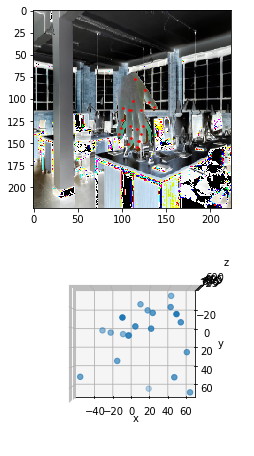

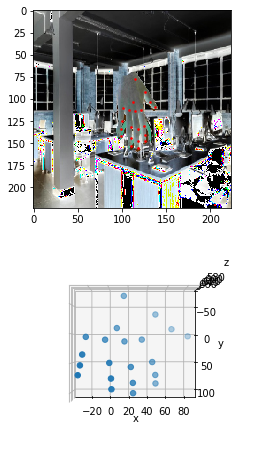

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at ..\src\TH\THGeneral.c:218

In [242]:
def makePosList(h_pred, l_pred):
    p2d_y, p2d_x = np.unravel_index(torch.argmax(h_pred.view(num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)

    p3d_x = l_pred[0:21, :, :].data.numpy()
    p3d_x = p3d_x[np.arange(len(p3d_x)), p2d_y, p2d_x]

    p3d_y = l_pred[21:42, :, :].data.numpy()
    p3d_y = p3d_y[np.arange(len(p3d_y)), p2d_y, p2d_x]

    p3d_z = l_pred[42:63, :, :].data.numpy()
    p3d_z = p3d_z[np.arange(len(p3d_z)), p2d_y, p2d_x]

    p3d = np.stack((p3d_x, p3d_y, p3d_z), axis=-1)
    
    return p2d, p3d

print("Evaluation...")
eval_loss = 0
eval_iter = 0
for idx, batch in enumerate(loader_train):
    eval_iter = idx
    image = batch['image'].float()
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    y_pred = model(image)
    h_pred = modelHeatmap(y_pred)
    l_pred = modelLocmap(y_pred)
    #print("output shape: {}".format(y_pred.shape))
    # use heatmap loss defined in VNect
    #loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
    
    #eval_loss = eval_loss + loss
    
    if idx == 0:
        # show some images
        p2d, p3d = makePosList(h_pred[0], l_pred[0])
        show_joints(image[0].data.numpy().transpose((1,2,0)), p2d, p3d)
        show_joints(image[0].data.numpy().transpose((1,2,0)), batch['pos_2d'][0], batch['pos_3d'][0])

#eval_iter = eval_iter + 1
#print("Eval Loss: {}".format(eval_loss / eval_iter))

**Save and load trained models**

In [245]:
#torch.save(model, 'model.pt')
#model = torch.load('model.pt')

# save/load only the model parameters(prefered solution)
torch.save(model.state_dict(), 'model_param.pt')
#model.load_state_dict(torch.load('model_param.pt'))